In [54]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

In [55]:
cols = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Deck_Cabin", "Side_Cabin"]
labelCols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck_Cabin", "Side_Cabin"]
numericalCols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
def preprocessingData(data):
    """
    The PassengerId and Name features don't provide any useful information that can help us predict the 
    Transported feature. The Cabin feature takes the form Deck/Num/Side. The Num part isn't too relevant 
    but the Deck and Side parts might be useful in predicting the Transported feature.
    """
    cabinSplit = data['Cabin'].str.split("/", expand=True)
    data['Deck_Cabin'] = cabinSplit[0]
    data['Side_Cabin'] = cabinSplit[2]
    data = data.drop(columns=["PassengerId", "Name", "Cabin"])
    
    #Filling the nan values in every numerical feature except Age with the mode value
    #Filling the nan values in the Age feature with the mean value
    #Standardizing the numerical columns so that all the values in these columns are on the same numerical scale
    #Filling the nan values in these categorical features with the mode value
    #Transforming the categorical features to store int labels
    label_encoder = preprocessing.LabelEncoder()
    for col in cols:
        if col in numericalCols:
            if col == "Age":
                data[col] = data[col].fillna(data[col].mean())
            else:
                data[col] = data[col].fillna(data[col].mode()[0])
            data[col] = (data[col] - data[col].mean())/(data[col].std())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            data[col] = label_encoder.fit_transform(data[col])
            data[col] = data[col].astype(int)
        
    return data


In [56]:
data = pd.read_csv("train.csv")
data = preprocessingData(data)
X = data.drop(columns=["Transported"])
y = data["Transported"]

#Using Bayesian Optimization to tune the hyperparameters
max_score = (0, {})
def generateGradientBoostingModel(estimator, max_features, learning_rate, depth):
    return GradientBoostingClassifier(n_estimators = estimator, max_features = max_features, 
                                      learning_rate = learning_rate, max_depth = depth)
    

def score(estimator, max_features, learning_rate, depth):
    estimator = round(estimator)
    max_features = round(max_features)
    depth = round(depth)
    
    def generateModel():
        return generateGradientBoostingModel(estimator, max_features, learning_rate, depth)
        
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    model = generateModel()
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=kfold)
    mean_acc = scores.mean()
    global max_score
    if mean_acc > max_score[0]:
        max_score = (mean_acc, {
            'estimator': estimator,
            'max_features': max_features,
            'learning_rate': learning_rate,
            'depth': depth
        })
    return mean_acc

hyperparams = {
    'estimator': (10, 1000),
    'max_features': (1, 12),
    'learning_rate': (0.0001, 1),
    'depth': (1,10)
}
start = time.time()
bo = BayesianOptimization(score, hyperparams, random_state=1)
bo.maximize(init_points=50, n_iter=10)
print("Best Accuracy: %f using %s" % (max_score[0], str(max_score[1])))
end = time.time()
elapsedTime = end - start
print("Elapsed Time: " + str(elapsedTime) + " seconds")

|   iter    |  target   |   depth   | estimator | learni... | max_fe... |
-------------------------------------------------------------------------
| 1         | 0.7894    | 4.753     | 723.1     | 0.0002144 | 4.326     |
| 2         | 0.7988    | 2.321     | 101.4     | 0.1863    | 4.801     |
| 3         | 0.7814    | 4.571     | 543.4     | 0.4193    | 8.537     |
| 4         | 0.8004    | 2.84      | 879.3     | 0.02748   | 8.375     |
| 5         | 0.7971    | 4.756     | 563.1     | 0.1405    | 3.179     |
| 6         | 0.7859    | 8.207     | 968.6     | 0.3135    | 8.616     |
| 7         | 0.7858    | 8.888     | 895.7     | 0.08514   | 1.43      |
| 8         | 0.8012    | 2.528     | 879.4     | 0.09844   | 5.632     |
| 9         | 0.7489    | 9.621     | 537.8     | 0.6919    | 4.471     |
| 10        | 0.798     | 7.179     | 836.3     | 0.01839   | 9.252     |
| 11        | 0.7838    | 9.9       | 750.7     | 0.2805    | 9.682     |
| 12        | 0.7886    | 1.929     | 

In [58]:
"""
According to the output, the hyperparameter values that displayed the best performance are
{'estimator': 272, 'max_features': 5, 'learning_rate': 0.06642820094499872, 'depth': 5}
"""

hyperparams = max_score[1]

"""
Precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
Recall is intuitively the ability of the classifier to find all the positive samples.
F1-score can be interpreted as a weighted harmonic mean of the precision and recall, where an F1-score 
reaches its best value at 1 and its worst score at 0.
"""
model = generateGradientBoostingModel(hyperparams['estimator'], hyperparams['max_features'], hyperparams['learning_rate'], hyperparams['depth'])
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.84      0.86      4315
        True       0.85      0.88      0.87      4378

    accuracy                           0.86      8693
   macro avg       0.86      0.86      0.86      8693
weighted avg       0.86      0.86      0.86      8693



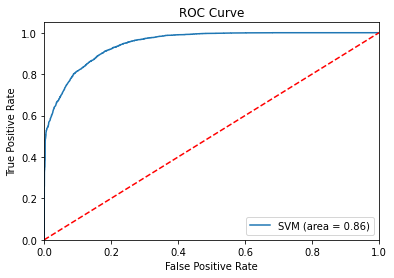

In [59]:
"""
The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away 
from that line as possible
"""
logit_roc_auc = roc_auc_score(y, y_pred)
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [60]:
#Final predictions on the test set to provide for submission
test_data = pd.read_csv("test.csv")
passenger_ids = test_data["PassengerId"]
test_data = preprocessingData(test_data)

model = generateGradientBoostingModel(hyperparams['estimator'], hyperparams['max_features'], hyperparams['learning_rate'], hyperparams['depth'])
model.fit(X, y)
y_pred = model.predict(test_data)

final_submission = pd.DataFrame()
final_submission["PassengerId"] = passenger_ids
final_submission["Transported"] = y_pred
final_submission.to_csv('GradientBoostingSubmission.csv', index=False)
#Final Submission Produced an accuracy of 0.77905 on the test set